# Generate initial designs for training data for ART

This notebook contains 3 ways of generating initial train data

In [1]:
import numpy as np
import pandas as pd
from random import randrange
import matplotlib.pyplot as plt
from pyDOE import *

All genes we might consider in relation to isopentenol production:

In [2]:
genes = ['ACCOAC', 
         'POX', # zero flux, can be forced
         'PTAr', 
         'CS', 
         'ACACT1r', 
         'PPC', 
         'PPCK', # zero flux
         'PFL', # zero flux, can be forced
         'PYK', # zero flux 
         'MDH']

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

In [22]:
modif_dict = {'KO': int(0), 
              'NoMod': int(1),
              'UP': int(2)}

How many genes you want to consider?

In [4]:
n_genes = int(input())


 7


How many instances you want to generate?

In [5]:
n_instances = int(input())

 48


In [17]:
n_modifications = len(modif_dict)
genes = genes[:n_genes]
tot_number_mod = n_modifications**n_genes
print(f'Total number of possible modifications: {tot_number_mod}')
trainingset = n_instances/tot_number_mod*100
print(f'Training set size: {n_instances} ({trainingset:.2f}%)')

Total number of possible modifications: 6561
Training set size: 100 (1.52%)


In [9]:
df = pd.DataFrame(columns=genes)
df.insert(loc=0, column='Line Name', value=None)

Define wild type strain with no modifications:

In [10]:
df.loc[0] = ['WT'] + [modif_dict['NoMod'] for i in range(n_genes)] 
df

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK
0,WT,1,1,1,1,1,1,1


### 1. Assign designs for the training set randomly (uniformly distributed among the options)

In [11]:
for i in range(1,n_instances):
    df.loc[i] = [str(i)] + [randrange(3) for j in range(n_genes)]
                            
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK
0,WT,1,1,1,1,1,1,1
1,1,1,1,2,0,0,1,1
2,2,0,2,2,1,2,1,2
3,3,1,2,0,0,0,0,1
4,4,0,0,0,2,2,0,2


How many modifications 'introduced' into each strain?

In [14]:
def num_of_modifications(df):
    num_instances = len(df)
    values = np.empty(num_instances)
    for i in range(num_instances):
        design = df.loc[i][1:]
        values[i] = list(design).count(0) + list(design).count(2)
    return values
            

In [13]:
df['# Modifs'] = num_of_modifications(df)
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK,# Modifs
0,WT,1,1,1,1,1,1,1,0.0
1,1,1,1,2,0,0,1,1,3.0
2,2,0,2,2,1,2,1,2,5.0
3,3,1,2,0,0,0,0,1,5.0
4,4,0,0,0,2,2,0,2,7.0


Find distribution of modifications per gene in the training data set:

In [14]:
df.loc[n_instances] = ['Summary'] + [[list(df[gene]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for gene in genes] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name                                              Summary
ACCOAC       [39.58333333333333, 33.33333333333333, 27.0833...
POX               [25.0, 39.58333333333333, 35.41666666666667]
PTAr         [29.166666666666668, 35.41666666666667, 35.416...
CS              [29.166666666666668, 20.833333333333336, 50.0]
ACACT1R           [33.33333333333333, 41.66666666666667, 25.0]
PPCK         [29.166666666666668, 41.66666666666667, 29.166...
PYK            [27.083333333333332, 43.75, 29.166666666666668]
# Modifs                                                4.4375
Name: 48, dtype: object

In [19]:
def plot_distribution(dataframe): 
    bar_height = 1
    labels = ['KO', 'NoMod', 'UP']
    colors = ['#019600', 'grey', '#219AD8']

    data = [ [dataframe[dataframe['Line Name']=='Summary'][g].values[0][num] for g in genes] 
            for num in range(n_modifications)]
    y_pos = np.arange(len(genes))

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111)

    # Remove frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    patch_handles = []
    # left alignment of data starts at zero
    left = np.zeros(len(genes)) 
    for i, d in enumerate(data):
        patch_handles.append(ax.barh(y_pos, d, 
                                     color=colors[i%len(colors)], edgecolor='white',
                                     height=bar_height, align='center', 
                                     left=left, label=labels[i]))
        left += d

    # search all of the bar segments and annotate
    for j in range(n_modifications):
        for i, patch in enumerate(patch_handles[j].get_children()):
            bl = patch.get_xy()
            x = 0.5*patch.get_width() + bl[0]
            y = 0.5*patch.get_height() + bl[1]
            ax.text(x,y, "%d%%" % (data[j][i]), ha='center')

    ax.set_title('Distribution of modifications')
    plt.tick_params(top='off', bottom='off', left='off', right='off', labelleft='on', 
                    labelbottom='off')
    plt.yticks(y_pos, genes)
    ax.invert_yaxis()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


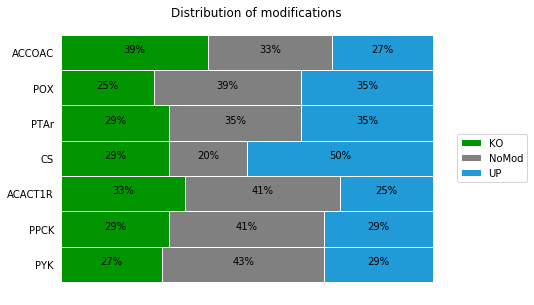

In [16]:
plot_distribution(df)

Save training set:

In [17]:
df.loc[0:n_instances].to_csv(f'./data/training_data_{n_genes}genes_unif.csv', 
                             columns = ['Line Name'] + genes, 
                             header = True, index = False)

### 2. Assign designs for the training set using Latin Hypercube sampling

In [18]:
df_lhs = df.copy()
df_lhs = df_lhs[df.columns[:-1]]
df_lhs.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK
0,WT,1,1,1,1,1,1,1
1,1,1,1,2,0,0,1,1
2,2,0,2,2,1,2,1,2
3,3,1,2,0,0,0,0,1
4,4,0,0,0,2,2,0,2


In [19]:
latin_hc = lhs(n_genes, samples=n_instances-1, criterion='maximin')
latin_hc = np.floor(3 * latin_hc)

for i in range(1,n_instances):
    designs = list(latin_hc[(i-1)])
    df_lhs.loc[i] = [str(i)] + designs 

df_lhs['# Modifs'] = num_of_modifications(df_lhs)

df_lhs.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1R,PPCK,PYK,# Modifs
0,WT,1,1,1,1,1,1,1,0.0
1,1,1,2,0,2,1,1,0,4.0
2,2,0,2,0,2,2,1,0,6.0
3,3,1,0,1,0,0,1,2,4.0
4,4,2,1,0,1,1,0,1,3.0


In [20]:
df_lhs.loc[n_instances] = ['Summary'] + [[list(df_lhs[gene]).count(int(i))/n_instances*100 
                                            for i in range(n_modifications)]  for gene in genes] + [np.mean(df_lhs['# Modifs'])]
df_lhs.iloc[-1]

Line Name                                              Summary
ACCOAC           [31.25, 35.41666666666667, 33.33333333333333]
POX              [31.25, 35.41666666666667, 33.33333333333333]
PTAr         [33.33333333333333, 33.33333333333333, 33.3333...
CS           [33.33333333333333, 33.33333333333333, 33.3333...
ACACT1R          [31.25, 35.41666666666667, 33.33333333333333]
PPCK         [33.33333333333333, 33.33333333333333, 33.3333...
PYK              [33.33333333333333, 35.41666666666667, 31.25]
# Modifs                                                4.4898
Name: 48, dtype: object

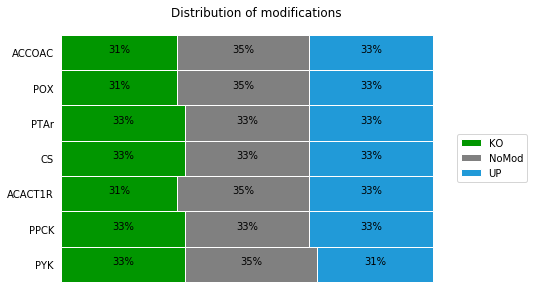

In [21]:
plot_distribution(df_lhs)

Save training set:

In [22]:
df.loc[0:n_instances].to_csv(f'./data/training_data_{n_genes}genes_lhs.csv', 
                             columns = ['Line Name'] + genes, 
                             header = True, index = False)

### 3. Assign designs for the training set using Latin Hypercube sampling through ART

In [1]:
# import numpy as np
# import pandas as pd
# from random import randrange
# import matplotlib.pyplot as plt

import sys
sys.path.append('../AutomatedRecommendationTool')
    
from art.core import *


/usr/local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
genes = ['ACCOAC', 
         'POX', # zero flux, can be forced
         'PTAr', 
         'CS', 
         'ACACT1r', 
         'PPC', 
         'PPCK', # zero flux
         'PFL', # zero flux, can be forced
         'PYK', # zero flux 
         'MDH']

Types of genetic modifications: 
- knockout (KO)
- no modification (NoMod)
- doubling the expression (UP)

In [3]:
modif_dict = {'KO': int(0), 
              'NoMod': int(1),
              'UP': int(2)}

How many genes you want to consider?

In [4]:
n_genes = int(input())


 8


How many instances you want to generate?

In [5]:
n_instances = int(input())

 100


In [6]:
art_params = {}
art_params['input_var'] = genes[:n_genes]
art_params['num_recommendations'] = n_instances - 1
art_params['initial_cycle'] = True
art_params['bounds_file'] = './data/bounds.csv'
art_params['seed'] = 10
art_params['output_directory'] = './art'


In [7]:
art = RecommendationEngine(**art_params)


In [9]:
df = art.recommendations.copy()
df.head()

,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
0,0.795864,1.785400,1.700735,0.574367,0.821748,1.552047,2.071725,1.280729
1,0.178965,0.034494,2.033663,2.441166,0.397357,2.103414,1.270302,2.422635
2,1.395676,2.442114,2.886140,1.564969,1.281542,2.910813,0.951475,1.573435
3,1.294897,1.926222,2.082841,0.599307,1.134819,2.709709,0.552649,2.892046
4,2.564929,2.737152,2.388253,2.652497,0.999300,1.237677,1.917104,0.430165


In [12]:
df.loc[n_instances-1] = [modif_dict['NoMod'] for i in range(n_genes)] 
df = np.floor(df)
df.tail()

,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
95,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0
96,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0
97,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0
98,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [13]:
df.insert(loc=0, column='Line Name', value=[str(i) for i in range(1,n_instances)]+['WT'])
df.tail()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL
95,96,1.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0
96,97,2.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0
97,98,0.0,0.0,2.0,1.0,2.0,1.0,2.0,1.0
98,99,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99,WT,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [15]:
df['# Modifs'] = num_of_modifications(df)
df.head()

,Line Name,ACCOAC,POX,PTAr,CS,ACACT1r,PPC,PPCK,PFL,# Modifs
0,1,0.0,1.0,1.0,0.0,0.0,1.0,2.0,1.0,4.0
1,2,0.0,0.0,2.0,2.0,0.0,2.0,1.0,2.0,7.0
2,3,1.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,4.0
3,4,1.0,1.0,2.0,0.0,1.0,2.0,0.0,2.0,5.0
4,5,2.0,2.0,2.0,2.0,0.0,1.0,1.0,0.0,6.0


In [18]:
df.loc[n_instances] = ['Summary'] + [[list(df[gene]).count(int(i))/n_instances*100 
                                      for i in range(n_modifications)]  
                                     for gene in genes] + [np.mean(df['# Modifs'])]
df.iloc[-1]

Line Name               Summary
ACCOAC       [33.0, 34.0, 33.0]
POX          [33.0, 34.0, 33.0]
PTAr         [33.0, 34.0, 33.0]
CS           [33.0, 34.0, 33.0]
ACACT1r      [33.0, 34.0, 33.0]
PPC          [33.0, 34.0, 33.0]
PPCK         [33.0, 34.0, 33.0]
PFL          [33.0, 34.0, 33.0]
# Modifs                   5.28
Name: 100, dtype: object

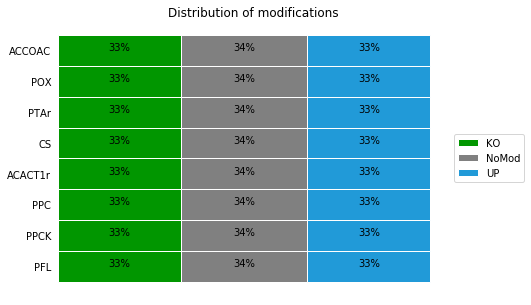

In [20]:
plot_distribution(df)

In [21]:
df.loc[(0:n_instances-1)].to_csv(f'./data/training_data_{n_genes}genes_ART.csv', 
                             columns = ['Line Name'] + genes, 
                             header = True, index = False)